In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from ipywidgets.widgets import interact
from IPython.display import HTML

from typing import Union, Any, List, Dict

from skimage import measure, morphology

import pydicom

In [2]:
def show_slice_array(arr: np.ndarray, **kwargs):
    plt.figure()
    print(f"Showing array with {arr.ndim=}")
    if arr.ndim != 3:
        plt.imshow(arr, **kwargs)
        plt.axis(False)
        plt.colorbar()
    else:
        def show_slice(i):
            plt.imshow(arr[i], **kwargs)
            plt.axis(False)
            plt.colorbar()
            return i
        interact(show_slice, i=(0, len(arr)-1))

In [3]:
def apply_mask(img, mask, maskval = 0):
    maskedimg = np.ma.masked_where(mask == maskval, img)
    return maskedimg

In [4]:
def show_4_panel_comp(patient_imgs: np.ndarray, mask_arr: np.ndarray, **kwargs):
    if patient_imgs.ndim != 3:
        patient_imgs = patient_imgs.reshape((1, patient_imgs.shape[0], patient_imgs.shape[1]))
    
    def show_slice(i):
        maskedimg = apply_mask(patient_imgs[i], mask_arr[i])
        inverseimg = apply_mask(patient_imgs[i], mask_arr[i], 1)

        palette = plt.cm.bone
        palette.set_bad("orchid")

        fig, axs = plt.subplots(2,2)
        fig.set_size_inches(10, 10)
        axs[0,0].imshow(patient_imgs[i], cmap=palette, interpolation="none")
        axs[0,0].axis(False)

        axs[0,1].imshow(mask_arr[i], cmap=plt.cm.bone, interpolation="none")
        axs[0,1].axis(False)

        axs[1,0].imshow(maskedimg, cmap=palette, interpolation="none")
        axs[1,0].axis(False)

        axs[1,1].imshow(inverseimg, cmap=palette, interpolation="none")
        axs[1,1].axis(False)
        return i
    interact(show_slice, i=range(len(patient_imgs)))

In [5]:
def largest_label_volume(labels: np.ndarray, bg=0):
    vals, counts = np.unique(labels, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

In [126]:
def get_tendon_mask2(img: np.ndarray, show_process: bool = False):
    get_bg_labels = lambda x: (x[img.shape[1]-1, 0], x[0, 0], x[0, img.shape[2]-1], x[img.shape[1]-1, img.shape[2]-1])
    if img.ndim != 3:
        img = img.reshape((1, img.shape[0], img.shape[1]))

    # Creem la imatge binaria a partir d'un cert valor de HU. Tendò = 1, Descartat = 2
    bin_img = np.array(img >= 1500, dtype=np.int8) + 1
    if show_process:
        print("Imatge binaria:")
        show_slice_array(np.ndarray.copy(bin_img))

    # Identifiquem les regions conectades per poder eliminar el fons.
    if show_process:
        intermediate = np.empty((0, bin_img.shape[1], bin_img.shape[2]), dtype=np.int8)
    for i, slice in enumerate(bin_img):
        labels = measure.label(slice, connectivity=1)

        if show_process:
            intermediate = np.concatenate((intermediate, labels.reshape((1, slice.shape[0], slice.shape[1]))))

        bg_labels = get_bg_labels(labels)
        bin_img[i][np.isin(labels, bg_labels)] = 2
    if show_process:
        print("Labels:")
        show_slice_array(np.ndarray.copy(intermediate))
        print("Fons eliminat:")
        show_slice_array(np.ndarray.copy(bin_img))

    # Posem Descartat = 0, Tendò = 1. Així les regions descartades comparteixen l'etiqueta del fons al fer measure.label().
    bin_img = -(bin_img-2)

    # De les regions restants després de filtrar les àrees per mida i area/perimetre,
    # ens quedem amb l'últim 5%. Llavors trobem la més gran que no sigui fons i la identifiquem com a tendò.
    if show_process:
        intermediate = np.empty((0, bin_img.shape[1], bin_img.shape[2]), dtype=np.int8)
        intermediate_smallfilter = np.empty((0, bin_img.shape[1], bin_img.shape[2]), dtype=np.int8)
        intermediate2 = np.empty((0, bin_img.shape[1], bin_img.shape[2]), dtype=np.int8)
        intermediate_closing = np.empty((0, bin_img.shape[1], bin_img.shape[2]), dtype=np.int8)
        intermediate3 = np.empty((0, bin_img.shape[1], bin_img.shape[2]), dtype=np.int8)
    for i, slice in enumerate(bin_img):
        labels2 = measure.label(slice)

        if show_process:
            intermediate = np.concatenate((intermediate, labels2.reshape((1, slice.shape[0], slice.shape[1]))))
        
        # Filtrem les àrees massa petites
        vals, counts = np.unique(labels2, return_counts=True)
        counts = counts[vals != 0]
        vals = vals[vals != 0]

        thres = np.max(counts)/20
        small_labels = vals[counts <= thres]
        labels2[np.isin(labels2, small_labels)] = 0

        if show_process:
            intermediate_smallfilter = np.concatenate((intermediate_smallfilter, labels2.reshape((1, slice.shape[0], slice.shape[1]))))

        # Filtrem les labels que tenen un perímetre massa gran respecte al àrea.
        labels_left = vals[np.isin(vals, small_labels, invert=True)]
        regprops = measure.regionprops(labels2)
        for reg in regprops:
            if reg.area/reg.perimeter < 3.1:
                labels2[labels2 == reg.label] = 0
        
        if show_process:
            intermediate2 = np.concatenate((intermediate2, labels2.reshape((1, slice.shape[0], slice.shape[1]))))
        
        # Convert to binary
        bin_img[i][labels2 == 0] = 0
        bin_img[i][labels2 != 0] = 1

        # Fem "morphological closing" per tal d'ajuntar àrees del tendó separades lleugerament
        bin_img[i] = morphology.closing(bin_img[i], morphology.diamond(5))

        if show_process:
            intermediate_closing = np.concatenate((intermediate_closing, bin_img[i].reshape((1, slice.shape[0], slice.shape[1]))))

        # Trobem l'àrea més gran de l'últim 5% (el 5% a la part més inferior de la imatge)
        labels2 = measure.label(bin_img[i])
        labels_left = np.unique(labels2)
        if len(labels_left) > 0:
            last_label = int(len(labels_left)*0.95) # De les labels que hi ha a la imatge, escollim l'index tal que el 5% de labels queden per sobre
            labels2[labels2 <= labels_left[last_label-1]] = 0

        if show_process:
            intermediate3 = np.concatenate((intermediate3, labels2.reshape((1, slice.shape[0], slice.shape[1]))))

        l_max = largest_label_volume(labels2)
        if l_max is not None:
            bin_img[i][labels2 != l_max] = 0
        l_max = largest_label_volume(labels2)
        if l_max is not None:
            bin_img[i][labels2 != l_max] = 0
    if show_process:
        print("Labels stacked:")
        show_slice_array(np.ndarray.copy(intermediate))
        print("Small filtered:")
        show_slice_array(np.ndarray.copy(intermediate_smallfilter))
        print("Labels area/perimeter:")
        show_slice_array(np.ndarray.copy(intermediate2))
        print("Morphological closing:")
        show_slice_array(np.ndarray.copy(intermediate_closing))
        print("Labels bottom 5%:")
        show_slice_array(np.ndarray.copy(intermediate3))
        print("Tendò seleccionat:")
        show_slice_array(np.ndarray.copy(bin_img))
    
    # Fem "morphological closing" per eliminar irregularitats i forats
    for i, slice in enumerate(bin_img):
        bin_img[i] = morphology.closing(slice, morphology.disk(10))
    if show_process:
        print("Morphological closing:")
        show_slice_array(np.ndarray.copy(bin_img))

    # Tornem a utilitzar 2 com a descartat, per poder detectar els forats d'aire
    bin_img = -(bin_img-2)
    # Ara tenim un array de slices on cada slice conté la segmentació utilitzant els mateixos números, Tendò = 1, Descartat = 2.
    # Si encara queden regions que no siguin fons ni tendò (forats d'aire), afegir-les a la segmentació
    if show_process:
        intermediate = np.empty((0, bin_img.shape[1], bin_img.shape[2]), dtype=np.int8)
    for i, slice in enumerate(bin_img):
        labels3 = measure.label(slice)

        if show_process:
            intermediate = np.concatenate((intermediate, labels3.reshape((1, slice.shape[0], slice.shape[1]))))

        bg_labels = get_bg_labels(labels3)
        l_max = largest_label_volume(labels2, bg_labels[0])
        if l_max is not None:
            bin_img[i][(labels3 != l_max) & (np.isin(labels3, bg_labels, invert=True))] = 1
    if show_process:
        print("Labels stacked:")
        show_slice_array(np.ndarray.copy(intermediate))
        print("Bombolles d'aire eliminades:")
        show_slice_array(np.ndarray.copy(bin_img))

    # Per últim convertim a Descartat = 0, Tendò = 1
    bin_img = -(bin_img-2)
    return bin_img

In [7]:
class Patient:
    def __init__(self, set_path: str) -> None:
        base_dir, _, file_list = list(os.walk(set_path))[-1]
        self.slices = [pydicom.dcmread(os.path.join(base_dir, s)) for s in file_list]
        self.slices.sort(key = lambda x: -int(x.InstanceNumber))
        self.n = len(self.slices)

        i = 0
        self.images = np.stack([s.pixel_array for s in self.slices])
        
    def __getitem__(self, ind):
        return self.images[ind]

# Data loading

In [102]:
dicom_path = r"Tendones_Anonymous"
normal_folder = r"normales"
patono_folder = r"patologicos_no_simpt"
pato_folder = r"patologicos_simpt"
subfolder = r"FILESET"

normal_list = [Patient(os.path.join(dicom_path, normal_folder, s)) for s in os.listdir(os.path.join(dicom_path, normal_folder))]
patono_list = [Patient(os.path.join(dicom_path, patono_folder, s)) for s in os.listdir(os.path.join(dicom_path, patono_folder))]
pato_list = [Patient(os.path.join(dicom_path, pato_folder, s)) for s in os.listdir(os.path.join(dicom_path, pato_folder))]

In [103]:
print(len(normal_list))
print(len(patono_list))
print(len(pato_list))

44
9
8


In [ ]:
show_slice_array(normal_list[0].images, cmap=plt.cm.bone)

Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=35), Output()), _dom_classes=('widget-interact'…

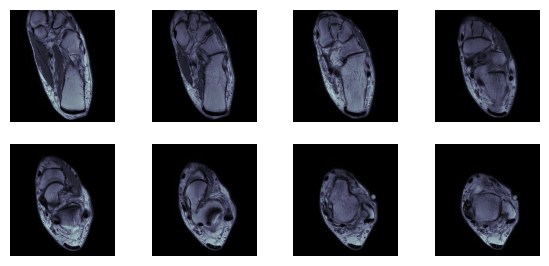

In [118]:
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(7,3.2))
for ax,i in zip(axs.flatten(), [8, 10, 12, 14, 16, 18, 20, 22]):
    ax.imshow(normal_list[0][i], cmap=plt.cm.bone)
    ax.axis('off')

### Normal

In [14]:
show_4_panel_comp(normal_list[0].images, get_tendon_mask2(normal_list[0].images, True))

Imatge binaria:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=35), Output()), _dom_classes=('widget-interact'…

Labels:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=35), Output()), _dom_classes=('widget-interact'…

Fons eliminat:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=35), Output()), _dom_classes=('widget-interact'…

Labels stacked:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=35), Output()), _dom_classes=('widget-interact'…

Small filtered:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=35), Output()), _dom_classes=('widget-interact'…

Labels area/perimeter:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=35), Output()), _dom_classes=('widget-interact'…

Morphological closing:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=35), Output()), _dom_classes=('widget-interact'…

Labels bottom 5%:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=35), Output()), _dom_classes=('widget-interact'…

Tendò seleccionat:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=35), Output()), _dom_classes=('widget-interact'…

Morphological closing:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=35), Output()), _dom_classes=('widget-interact'…

Labels stacked:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=35), Output()), _dom_classes=('widget-interact'…

Bombolles d'aire eliminades:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=35), Output()), _dom_classes=('widget-interact'…

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [19]:
show_4_panel_comp(normal_list[1].images, get_tendon_mask2(normal_list[1].images, True))

Imatge binaria:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Labels:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Fons eliminat:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Labels stacked:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Small filtered:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Labels area/perimeter:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Morphological closing:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Labels bottom 5%:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Tendò seleccionat:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Morphological closing:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Labels stacked:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Bombolles d'aire eliminades:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [56]:
show_4_panel_comp(normal_list[2].images, get_tendon_mask2(normal_list[2].images, True))

Imatge binaria:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=34), Output()), _dom_classes=('widget-interact'…

Labels:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=34), Output()), _dom_classes=('widget-interact'…

Fons eliminat:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=34), Output()), _dom_classes=('widget-interact'…

Labels stacked:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=34), Output()), _dom_classes=('widget-interact'…

Small filtered:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=34), Output()), _dom_classes=('widget-interact'…

Labels area/perimeter:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=34), Output()), _dom_classes=('widget-interact'…

Morphological closing:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=34), Output()), _dom_classes=('widget-interact'…

Labels bottom 5%:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=34), Output()), _dom_classes=('widget-interact'…

Tendò seleccionat:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=34), Output()), _dom_classes=('widget-interact'…

Morphological closing:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=34), Output()), _dom_classes=('widget-interact'…

Labels stacked:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=34), Output()), _dom_classes=('widget-interact'…

Bombolles d'aire eliminades:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=17, description='i', max=34), Output()), _dom_classes=('widget-interact'…

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

### Pathological

In [57]:
show_4_panel_comp(pato_list[1].images, get_tendon_mask2(pato_list[1].images, True))

Imatge binaria:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=16, description='i', max=33), Output()), _dom_classes=('widget-interact'…

Labels:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=16, description='i', max=33), Output()), _dom_classes=('widget-interact'…

Fons eliminat:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=16, description='i', max=33), Output()), _dom_classes=('widget-interact'…

Labels stacked:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=16, description='i', max=33), Output()), _dom_classes=('widget-interact'…

Small filtered:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=16, description='i', max=33), Output()), _dom_classes=('widget-interact'…

Labels area/perimeter:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=16, description='i', max=33), Output()), _dom_classes=('widget-interact'…

Morphological closing:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=16, description='i', max=33), Output()), _dom_classes=('widget-interact'…

Labels bottom 5%:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=16, description='i', max=33), Output()), _dom_classes=('widget-interact'…

Tendò seleccionat:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=16, description='i', max=33), Output()), _dom_classes=('widget-interact'…

Morphological closing:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=16, description='i', max=33), Output()), _dom_classes=('widget-interact'…

Labels stacked:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=16, description='i', max=33), Output()), _dom_classes=('widget-interact'…

Bombolles d'aire eliminades:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=16, description='i', max=33), Output()), _dom_classes=('widget-interact'…

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [58]:
show_4_panel_comp(pato_list[0].images, get_tendon_mask2(pato_list[0].images, True))

Imatge binaria:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=19, description='i', max=39), Output()), _dom_classes=('widget-interact'…

Labels:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=19, description='i', max=39), Output()), _dom_classes=('widget-interact'…

Fons eliminat:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=19, description='i', max=39), Output()), _dom_classes=('widget-interact'…

Labels stacked:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=19, description='i', max=39), Output()), _dom_classes=('widget-interact'…

Small filtered:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=19, description='i', max=39), Output()), _dom_classes=('widget-interact'…

Labels area/perimeter:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=19, description='i', max=39), Output()), _dom_classes=('widget-interact'…

Morphological closing:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=19, description='i', max=39), Output()), _dom_classes=('widget-interact'…

Labels bottom 5%:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=19, description='i', max=39), Output()), _dom_classes=('widget-interact'…

Tendò seleccionat:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=19, description='i', max=39), Output()), _dom_classes=('widget-interact'…

Morphological closing:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=19, description='i', max=39), Output()), _dom_classes=('widget-interact'…

Labels stacked:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=19, description='i', max=39), Output()), _dom_classes=('widget-interact'…

Bombolles d'aire eliminades:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=19, description='i', max=39), Output()), _dom_classes=('widget-interact'…

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [59]:
show_4_panel_comp(pato_list[2].images, get_tendon_mask2(pato_list[2].images))

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [60]:
show_4_panel_comp(pato_list[3].images, get_tendon_mask2(pato_list[3].images))

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

### Pathological asimp

In [61]:
show_4_panel_comp(patono_list[0].images, get_tendon_mask2(patono_list[0].images))

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [32]:
show_4_panel_comp(patono_list[1].images, get_tendon_mask2(patono_list[1].images, True))

Imatge binaria:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Labels:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Fons eliminat:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Morphological closing:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Labels stacked:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Small filtered:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Labels area/perimeter:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Labels bottom 5%:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Tendò seleccionat:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Morphological closing:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Labels stacked:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

Bombolles d'aire eliminades:
Showing array with arr.ndim=3


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=12, description='i', max=24), Output()), _dom_classes=('widget-interact'…

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [36]:
show_4_panel_comp(patono_list[2].images, get_tendon_mask2(patono_list[2].images))

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

### Generate all masks and comparision

In [51]:
def save_4_panel_comp(name, patient_imgs: np.ndarray, mask_arr: np.ndarray, **kwargs):
    if patient_imgs.ndim != 3:
        patient_imgs = patient_imgs.reshape((1, patient_imgs.shape[0], patient_imgs.shape[1]))
    
    for i in range(len(patient_imgs)):
        maskedimg = apply_mask(patient_imgs[i], mask_arr[i])
        inverseimg = apply_mask(patient_imgs[i], mask_arr[i], 1)

        palette = plt.cm.bone
        palette.set_bad("orchid")

        fig, axs = plt.subplots(2,2)
        fig.set_size_inches(10, 10)
        axs[0,0].imshow(patient_imgs[i], cmap=palette, interpolation="none")
        axs[0,0].axis(False)

        axs[0,1].imshow(mask_arr[i], cmap=plt.cm.bone, interpolation="none")
        axs[0,1].axis(False)

        axs[1,0].imshow(maskedimg, cmap=palette, interpolation="none")
        axs[1,0].axis(False)

        axs[1,1].imshow(inverseimg, cmap=palette, interpolation="none")
        axs[1,1].axis(False)
        fig.savefig(f"comparisions/panels_{name}_{i}.png")
        plt.close(fig)

In [ ]:
for i,patient in enumerate(normal_list + pato_list + patono_list):
    save_4_panel_comp(str(i), patient.images[10:], get_tendon_mask2(patient.images[10:]))

## 3D representation

In [129]:
patient_mask = get_tendon_mask2(normal_list[0].images)

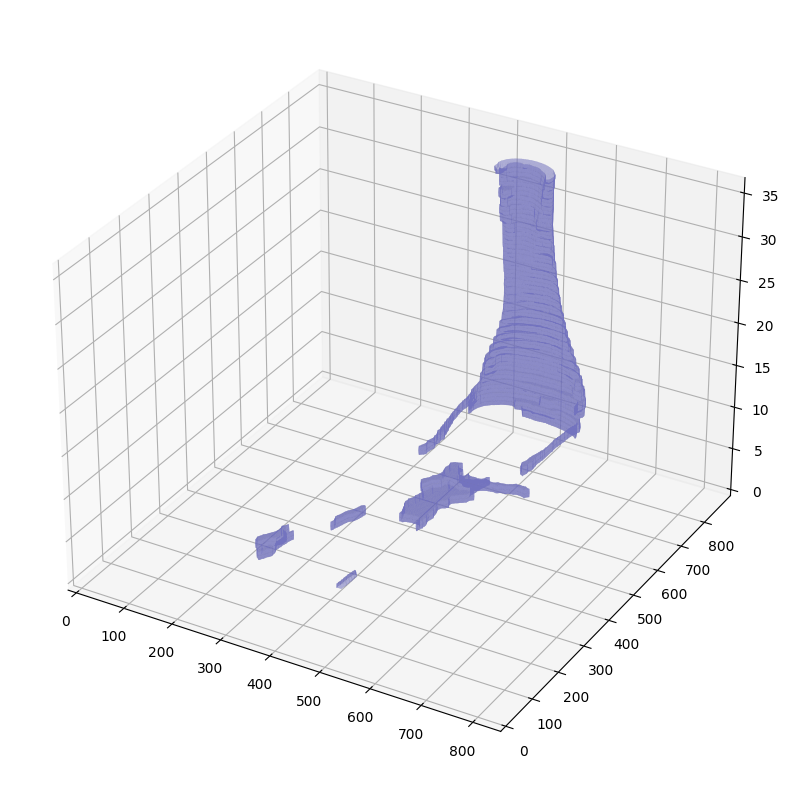

In [130]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d(image):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the   
    # camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes(p)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of    
    # triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    return fig, ax

plot_3d(patient_mask)
plt.show()

In [ ]:
# Interactive
import ipyvolume as ipv

p = patient_mask.transpose(2,0,1)
verts, faces, _, _ = measure.marching_cubes(p)
ipv.figure()
mesh = ipv.plot_trisurf(verts[:,0], verts[:,1], verts[:,2], faces, color='cyan')
mesh.color = [0.2, 0.2, 1.5, 0.5]
mesh.material.transparent = True
ipv.show()

ipv.save("patient1.html", offline=True)

## Validation of classical image processing method with manually labelled images

In [97]:
def get_values(y_true, y_pred):
    """# True Positives
    tp = np.sum(np.logical_and(y_pred == 1, y_true == 1))
    # True Negatives
    tn = np.sum(np.logical_and(y_pred == 0, y_true == 0))
    # False Positives
    fp = np.sum(np.logical_and(y_pred == 1, y_true == 0))
    # False Negatives
    fn = np.sum(np.logical_and(y_pred == 0, y_true == 1))
    return tn, fp, fn, tp"""

    tp = np.sum((y_pred == 1) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    return tn, fp, fn, tp



def sensitivity(y_true, y_pred, epsilon=1e-20):
    tn, fp, fn, tp = get_values(y_true, y_pred)
    res = (tp) / (tp + fn + epsilon)
    return res


def specificity(y_true , y_pred, epsilon=1e-20):
    tn, fp, _, _ = get_values(y_true, y_pred)
    res = (tn)/(tn+fp+epsilon)
    return res

def accuracy(y_true, y_pred, epsilon=1e-20):
    tn, fp, fn, tp = get_values(y_true, y_pred)
    res = (tp+tn)/(tp+fp+tn+fn+epsilon)
    return res

def jaccard(y_true, y_pred):
    tn, fp, fn, tp = get_values(y_true, y_pred)
    return (tp)/(tp+fp+fn)

def dice_coef(y_true, y_pred, epsilon=1e-20):
    _ , fp, fn, tp = get_values(y_true, y_pred)
    res = (2*tp)/(2*tp+fp+fn+epsilon)
    return res

def precision(y_true, y_pred, epsilon=1e-20):
  tn, fp, fn, tp = get_values(y_true, y_pred)
  res = tp/(tp+fp+epsilon)
  return res

def iou_metric(y_true: np.array, y_preds: np.array, epsilon=1e-6):
    
    intersection = ((y_preds == 1) & (y_true == 1)).sum()
    union = ((y_preds == 1) | (y_true == 1)).sum()
    
    iou = (intersection + epsilon) / (union + epsilon)
    
    return iou

In [54]:
from PIL import Image
from pathlib import Path

images_path = Path("labelled_data") / "content"
normal_folder = r"normals"
asimp_folder = r"asimpt"
pato_folder = r"simpt"

normal_list = [plt.imread(images_path / normal_folder / f"{i}.png")[:,:,0] for i in range(len(os.listdir(images_path / normal_folder)))]
asimp_list = [plt.imread(images_path / asimp_folder / f"{i}.png")[:,:,0] for i in range(len(os.listdir(images_path / asimp_folder)))]
pato_list = [plt.imread(images_path / pato_folder / f"{i}.png")[:,:,0] for i in range(len(os.listdir(images_path / pato_folder)))]

In [55]:
print(len(normal_list))
print(len(asimp_list))
print(len(pato_list))

416
157
184


In [100]:
416 +157 +184

757

In [59]:
normal_mask_folder = r"mask_normals"
asimp_mask_folder = r"mask_asimpt"
pato_mask_folder = r"mask_simpt"

normal_mask_list = [plt.imread(images_path / normal_mask_folder / f"{i}.png")[:,:,0] for i in range(len(os.listdir(images_path / normal_mask_folder)))]
asimp_mask_list = [plt.imread(images_path / asimp_mask_folder / f"{i}.png")[:,:,0] for i in range(len(os.listdir(images_path / asimp_mask_folder)))]
pato_mask_list = [plt.imread(images_path / pato_mask_folder / f"{i}.png")[:,:,0] for i in range(len(os.listdir(images_path / pato_mask_folder)))]

In [60]:
print(len(normal_mask_list))
print(len(asimp_mask_list))
print(len(pato_mask_list))

416
157
184


Sensitivity (normal): 0.8686708670291103
Specificity (normal): 0.9995733207210418
Accuracy (normal): 0.9990752809611899
jaccard (normal): 0.8159809275275666
dice_val (normal): 0.8685231496057053
precision (normal): 0.8736857902758838
iou (normal): 0.8159809275834606
Sensitivity (asimp): 0.9163539438133488
Specificity (asimp): 0.9996938737707928
Accuracy (asimp): 0.999330577651952
jaccard (asimp): 0.8589288325088491
dice_val (asimp): 0.9171057800616721
precision (asimp): 0.9227978048448567
iou (asimp): 0.858928832549973
Sensitivity (patho): 0.8463079509076279
Specificity (patho): 0.9997426666076304
Accuracy (patho): 0.9986706787538836
jaccard (patho): 0.8112650184394793
dice_val (patho): 0.8642608131928313
precision (patho): 0.8998609062061785
iou (patho): 0.811265018487907
Sensitivity (total): 0.8731245876219403
Specificity (total): 0.9996394851489723
Accuracy (total): 0.9990298843618578
jaccard (total): 0.8237419497334487
dice_val (total): 0.877563047996218
precision (total): 0.890233

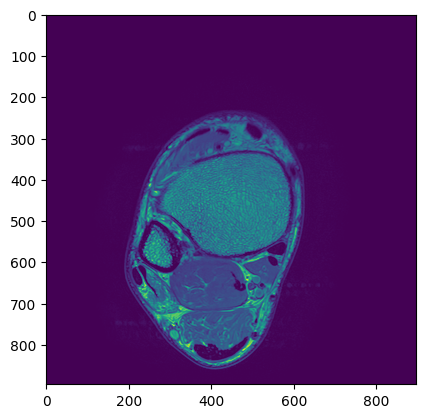

In [99]:
sensitivity_val_tot = 0
accuracy_val_tot = 0
specificity_val_tot = 0
jaccard_val_tot = 0
dice_val_tot = 0
precision_val_tot = 0
iou_val_tot = 0

for image_list, image_mask_list, group_name in zip([normal_list, asimp_list, pato_list], [normal_mask_list, asimp_mask_list, pato_mask_list], ["normal", "asimp", "patho"]):
    sensitivity_val = 0
    accuracy_val = 0
    specificity_val = 0
    jaccard_val = 0
    dice_val = 0
    precision_val = 0
    iou_val = 0

    for slice,label in zip(image_list, image_mask_list):
        plt.imshow(slice)
        prediction = get_tendon_mask2(slice) 

        sens = sensitivity(label, prediction)
        sensitivity_val += sens
        sensitivity_val_tot += sens

        spec = specificity(label, prediction)
        specificity_val += spec
        specificity_val_tot += spec

        acc = accuracy(label, prediction)
        accuracy_val += acc
        accuracy_val_tot += acc

        jacc = jaccard(label,prediction)
        jaccard_val += jacc
        jaccard_val_tot += jacc

        dice = dice_coef(label, prediction)
        dice_val += dice
        dice_val_tot += dice

        prec = precision(label, prediction)
        precision_val += prec
        precision_val_tot += prec

        iou = iou_metric(label, prediction)
        iou_val += iou
        iou_val_tot += iou
    print(f"Sensitivity ({group_name}):", sensitivity_val/len(image_list))
    print(f"Specificity ({group_name}):", specificity_val/len(image_list))
    print(f"Accuracy ({group_name}):", accuracy_val/len(image_list))
    print(f"jaccard ({group_name}):", jaccard_val/len(image_list))
    print(f"dice_val ({group_name}):", dice_val/len(image_list))
    print(f'precision ({group_name}):', precision_val/(len(image_list)))
    print(f"iou ({group_name}):", iou_val/len(image_list))

total_images = len(normal_list) + len(asimp_list) + len(pato_list)
print(f"Sensitivity (total):", sensitivity_val_tot/total_images)
print(f"Specificity (total):", specificity_val_tot/total_images)
print(f"Accuracy (total):", accuracy_val_tot/total_images)
print(f"jaccard (total):", jaccard_val_tot/total_images)
print(f"dice_val (total):", dice_val_tot/total_images)
print(f'precision (total):', precision_val_tot/total_images)
print(f"iou (total):", iou_val_tot/total_images)

# Dataset creation

In [40]:
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
import os
from pathlib import Path

def get_label_strings(patient, min_slice):
    masks = get_tendon_mask2(patient.images[min_slice:])

    labels = []
    for slice in np.uint8(masks):
        conts, _ = cv2.findContours(slice, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        label_line = '0 ' + ' '.join([f'{int(point[0][0])/slice.shape[0]} {int(point[0][1])/slice.shape[1]}' for point in conts[0]])
        labels.append(label_line)
    return labels

def include_with_labels(patients, split_str, min_slice, imgsize):
    for i, patient in enumerate(patients):
        diffx = patient.images.shape[1] - imgsize
        diffy = patient.images.shape[2] - imgsize
        if diffx < 0:
            patient.images = np.pad(patient.images, [(0, 0), (0, -diffx), (0, 0)])
        if diffy < 0:
            patient.images = np.pad(patient.images, [(0, 0), (0, 0), (0, -diffy)])
        if diffx > 0:
            patient.images = patient.images[ : , diffx:, :]
        if diffy > 0:
            patient.images = patient.images[ : , : , diffy:]

        labels = get_label_strings(patient, min_slice)
        path = Path(f"dataset/{split_str}/images")
        path.mkdir(parents=True, exist_ok=True)
        path = Path(f"dataset/{split_str}/labels")
        path.mkdir(parents=True, exist_ok=True)
        for j, slice in enumerate(patient.images[min_slice:]): # We will not use the first {min_slice} slices since they usually don't show any tendon
            im = Image.fromarray(slice)
            im.save(f"dataset/{split_str}/images/img_{i}_{j}.png")

            with open(f"dataset/{split_str}/labels/img_{i}_{j}.txt", "w") as f:
                f.write(labels[j])

def create_dataset(normal_patients, asimp_patients, pato_patients, min_slice, imgsize):
    normal_train, normal_rem = train_test_split(normal_patients, train_size=0.8)
    asimp_train, asimp_rem = train_test_split(asimp_patients, train_size=0.8)
    pato_train, pato_rem = train_test_split(pato_patients, train_size=0.8)

    include_with_labels(normal_train + asimp_train + pato_train, "train", min_slice, imgsize)
    
    normal_test, normal_val = train_test_split(normal_rem, train_size=0.5)
    asimp_test, asimp_val = train_test_split(asimp_rem, train_size=0.5)
    pato_test, pato_val = train_test_split(pato_rem, train_size=0.5)

    include_with_labels(normal_test + asimp_test + pato_test, "test", min_slice, imgsize)

    include_with_labels(normal_val + asimp_val + pato_val, "val", min_slice, imgsize)

create_dataset(normal_list, patono_list, pato_list, 10, 896)

# Train

In [43]:
from ultralytics import YOLO

modelten = YOLO("yolov8s-seg.pt")

modelten.train(batch=8, data="tendons.yaml", epochs=100, imgsz=896)

Ultralytics YOLOv8.0.121  Python-3.11.3 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1060 6GB, 6144MiB)
yolo\engine\trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=tendons.yaml, epochs=100, patience=50, batch=8, imgsz=896, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, 

## Validation

In [121]:
from ultralytics import YOLO
YOLO("runs/segment/train4/weights/best.pt").val()

Ultralytics YOLOv8.0.121  Python-3.11.3 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1060 6GB, 6144MiB)
YOLOv8s-seg summary (fused): 195 layers, 11779987 parameters, 0 gradients
val: Scanning C:\Users\Goyo\Desktop\Goio\TFG Mates\dataset\val\labels.cache... 116 images, 0 backgrounds, 0 corrupt: 100%|██████████| 116/116 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:15<00:00,  1.99s/it]
                   all        116        116       0.91      0.879      0.944      0.889       0.91      0.879      0.949       0.84
Speed: 3.0ms preprocess, 109.5ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\segment\val2


ultralytics.yolo.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.yolo.utils.metrics.Metric object
confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x00000238F5803790>
fitness: 1.7459850512909512
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(M)', 'metrics/recall(M)', 'metrics/mAP50(M)', 'metrics/mAP50-95(M)']
maps: array([     1.7297])
names: {0: 'tendon'}
plot: True
results_dict: {'metrics/precision(B)': 0.9102415869685079, 'metrics/recall(B)': 0.8793103448275862, 'metrics/mAP50(B)': 0.9436959834544353, 'metrics/mAP50-95(B)': 0.8893746631691786, 'metrics/precision(M)': 0.9102415869685079, 'metrics/recall(M)': 0.8793103448275862, 'metrics/mAP50(M)': 0.9490573505156282, 'metrics/mAP50-95(M)': 0.8403028011574266, 'fitness': 1.7459850512909512}
save_dir: WindowsPath('runs/segment/val2')
seg: ultralytics.yolo.utils.metrics.Metric object
speed: {'pr